# Two analysers - DeepTaylor and PatternAttribution of the classification model on many images of the  on Triangles and Squares (Rotaion & Scaling) dataset using iNNvestigate 

## Imports

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import imp
import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

import innvestigate
import innvestigate.utils as iutils
mnistutils = imp.load_source("utils_mnist", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils_mnist.py")
eutils = imp.load_source("utils", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils.py")

from code import shape_images as shi


Using TensorFlow backend.


## Load the data

In [2]:
# filenames
# data paths
original_data_path = "/home/elena/eStep/XAI/Data/TrianglesAndSquaresRotationScale"

train_data_fname = os.path.join(original_data_path, 'split_npz','train_data.npz')
test_data_fname = os.path.join(original_data_path, 'split_npz','test_data.npz')

# loading
train_data = np.load(train_data_fname)
test_data = np.load(test_data_fname)

In [3]:
images_train = train_data['images_train']
labels_train = train_data['labels_train']
images_test = test_data['images_test']
labels_test_or = test_data['labels_test']

print("Size of training data: ", np.shape(images_train), "and labels: ", np.shape(labels_train))
print("Size of testing data: ", np.shape(images_test), "and labels: ", np.shape(labels_test_or))

Size of training data:  (14000, 4096) and labels:  (14000,)
Size of testing data:  (2000, 4096) and labels:  (2000,)


In [4]:
img_rows = 64
img_cols = 64
if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], 1, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, 1)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print("Size of training data: ", np.shape(images_train))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (14000, 64, 64, 1)
Size of testing data:  (2000, 64, 64, 1)


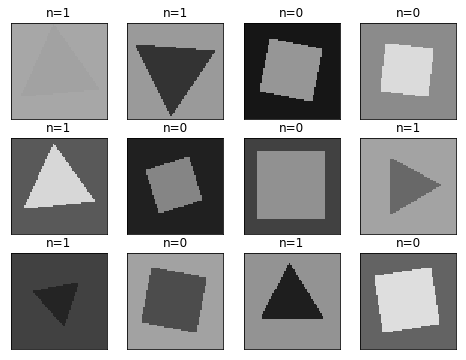

In [5]:
# plot 12 random train images
shi.plot_12images(images_train, labels_train) 

### Labels formatting

In [6]:
# convert class vectors to binary class matrices
labels_train = np_utils.to_categorical(labels_train, num_classes=2)
labels_test = np_utils.to_categorical(labels_test_or, num_classes=2)
print(labels_train)
print('labels_train shape:', labels_train.shape)
print('labels_test shape:', labels_test.shape)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
labels_train shape: (14000, 2)
labels_test shape: (2000, 2)


## Model

In [7]:
# filename for model 
model_fname = os.path.join(original_data_path, 'Models','model.h5')

# load the trained model
model = load_model(model_fname) 
print("Loaded model from disk")

Loaded model from disk


Evaluate on test images.

In [8]:
score = model.evaluate(images_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

Test loss: 0.10065763419866562
Test accuracy: 97.65 %


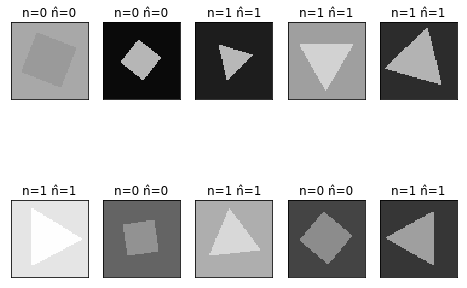

In [9]:
# pick up 10 random images and classify them using the trained model
import matplotlib.cm as cm

figsize = (8, 6)
plt.figure(figsize=figsize)
j=0
nim = len(labels_test_or)

for _ in range(10):
    ind=int(np.random.randint(1,nim))
    img=images_test[ind,:]
    img=np.reshape(img,(64,64))
    X = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
    label=labels_test_or[ind]
       
    predictions = model.predict(X);
    pred = np.argmax(predictions) 
    
    j = j+1
    plt.subplot(2, 5, j)
    plt.imshow(img*255,cmap=cm.gray, vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([])
    plt.title('n=%d n̂=%d' % (label, pred))

plt.show()


Determine the indicies of the missclassified images and display some of them.

In [10]:
predictions = model.predict(images_test)
indices_wrong = [i for i,v in enumerate(predictions) if np.argmax(predictions[i])!=np.argmax(labels_test[i])]
print('Missclassified images: ', len(indices_wrong)/len(labels_test)*100, '%')

Missclassified images:  2.35 %


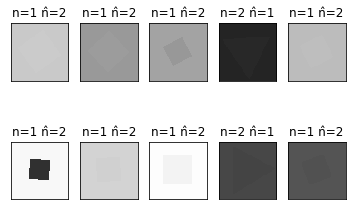

In [11]:
# display the first 10 missclassified images 

for i in range(10):
      
    ind = indices_wrong[i]
    img = images_test[ind].reshape(img_rows, img_cols)
    lab = np.argmax(labels_test[ind])+1 # we subtracted 1 before
    pred = np.argmax(predictions[ind])+1
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img*255,cmap=cm.gray, vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([]) 
    plt.title('n=%d n̂=%d' % (lab, pred))

plt.show()

## Analysis

Define a list of top analysis methods by preparing tuples containing the methods' string identifiers used by innvestigate.analyzer.create_analyzer(...), some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render.

In [12]:
# parameters
input_range = [0, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(images_test, input_range)
def input_postprocessing(X):
    #return revert_preprocessing(X) / 255
    return 1-X


noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
methods = [
    # NAME            OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",         {},                       input_postprocessing,      "Input"),

    # Signal
 #   ("pattern.net",   {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"), 


    # Interaction
    ("pattern.attribution",  {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
       
    ("deep_taylor.bounded",   {"low": input_range[0],"high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
    
#    ("input_t_gradient",     {},                        mnistutils.heatmap,        "Input * Gradient"),
    
#    ("integrated_gradients", {"reference_inputs": ri},  mnistutils.heatmap,        "Integrated Gradients"), 

#    ("lrp.z",                {},                        mnistutils.heatmap,        "LRP-Z"),
]
    
print('Considered number of explainability methods:', len(methods)-1)

Considered number of explainability methods: 2


The main loop instantiates the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [13]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

path_to_analyzers = "/home/elena/eStep/XAI/Data/TrianglesAndSquaresRotationScale/Analyzers/"  


# Create analyzers.
analyzers = []
for method in methods:
    fname = os.path.join(path_to_analyzers, method[0]+'.npz')
    
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            neuron_selection_mode="index",
                                            **method[1])     
    
    if os.path.isfile(fname) :
        print("Analyzer", method[0], "exists! Loading...")
        analyzer = analyzer.load_npz(fname)
    else:
        print("Analyzer", method[0], " doesn't exist! Creating and possibly Training and [Saving]...")
        # Some analyzers require training.
        analyzer.fit(images_train, batch_size=50, verbose=1)
        if (method[0]=='pattern.net') or (method[0]=='pattern.attribution'):
            analyzer.save_npz(fname)
    
    analyzers.append(analyzer)


Analyzer input  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer pattern.attribution exists! Loading...
Analyzer deep_taylor.bounded  doesn't exist! Creating and possibly Training and [Saving]...


Analyze random set of test images with the different analyzers on all output neurons:

--------------------------------------------------------------------------------
Image nr. 767; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

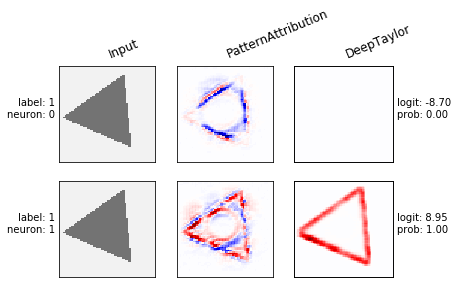

--------------------------------------------------------------------------------
Image nr. 768; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

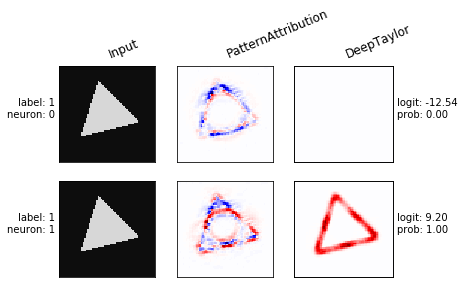

--------------------------------------------------------------------------------
Image nr. 769; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

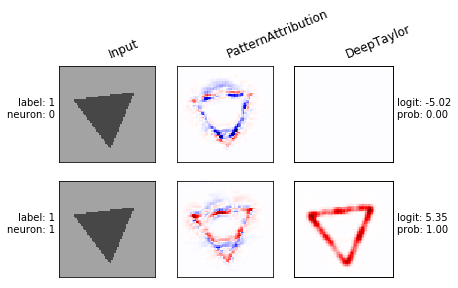

--------------------------------------------------------------------------------
Image nr. 770; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

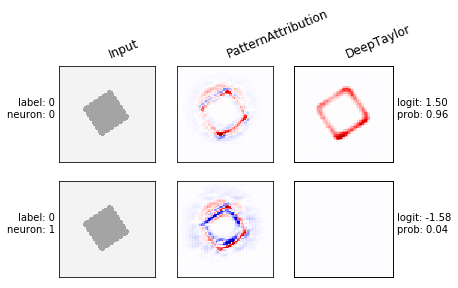

--------------------------------------------------------------------------------
Image nr. 771; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

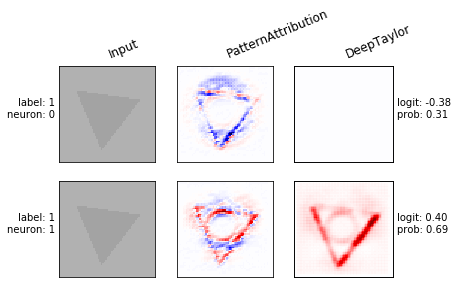

--------------------------------------------------------------------------------
Image nr. 772; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

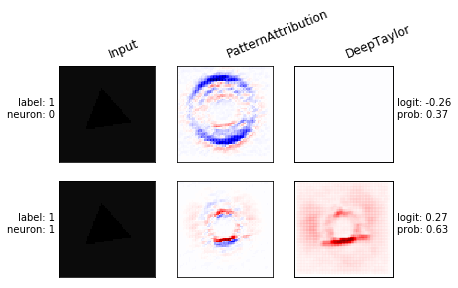

--------------------------------------------------------------------------------
Image nr. 773; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

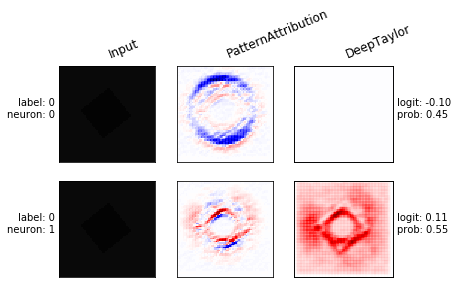

--------------------------------------------------------------------------------
Image nr. 774; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

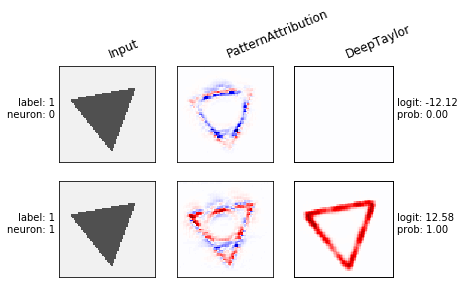

--------------------------------------------------------------------------------
Image nr. 775; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

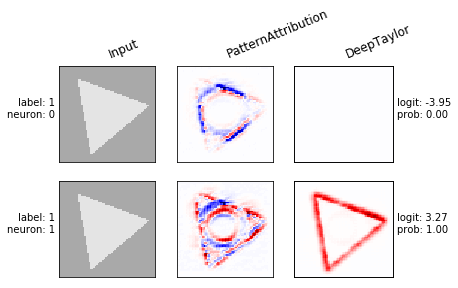

--------------------------------------------------------------------------------
Image nr. 776; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

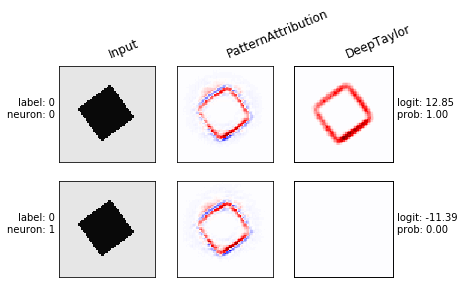

--------------------------------------------------------------------------------
Image nr. 777; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

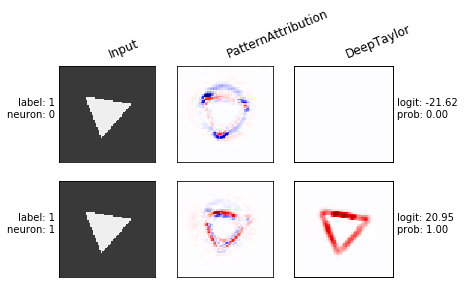

--------------------------------------------------------------------------------
Image nr. 778; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

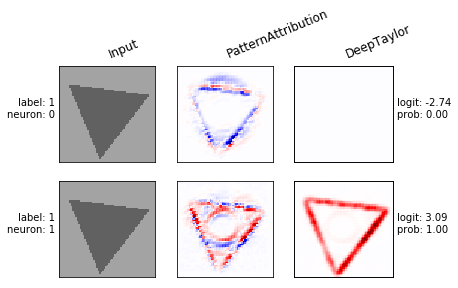

--------------------------------------------------------------------------------
Image nr. 779; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

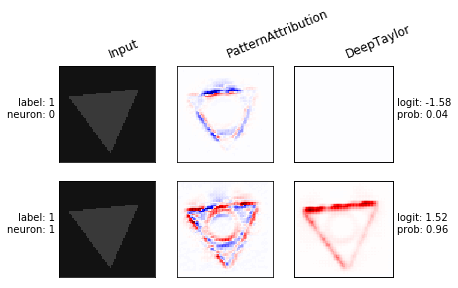

--------------------------------------------------------------------------------
Image nr. 780; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

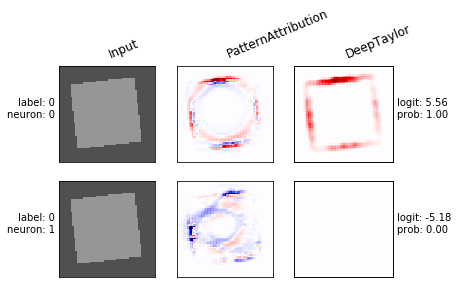

--------------------------------------------------------------------------------
Image nr. 781; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

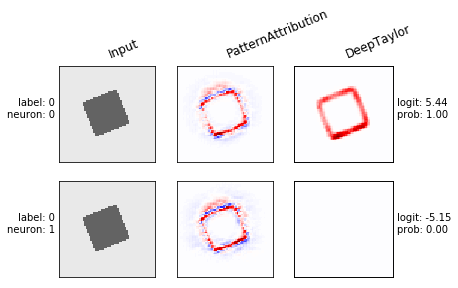

--------------------------------------------------------------------------------
Image nr. 782; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

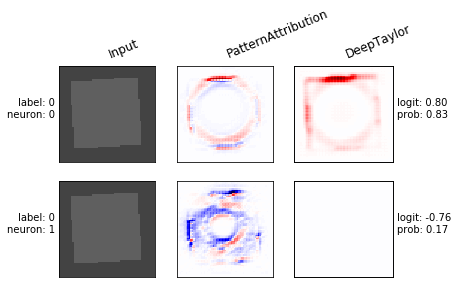

--------------------------------------------------------------------------------
Image nr. 783; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

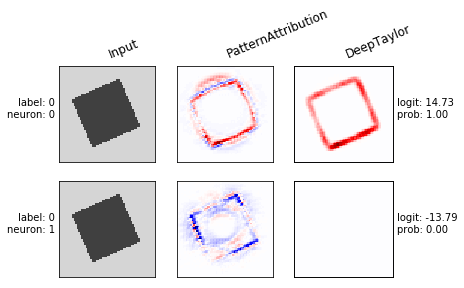

--------------------------------------------------------------------------------
Image nr. 784; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

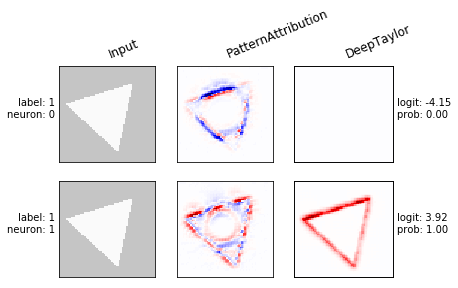

--------------------------------------------------------------------------------
Image nr. 785; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

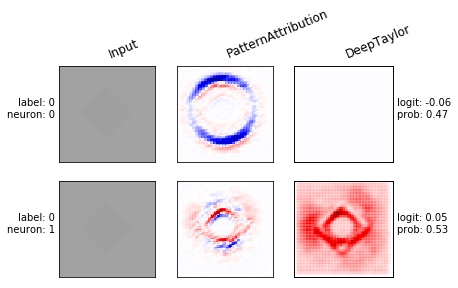

--------------------------------------------------------------------------------
Image nr. 786; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

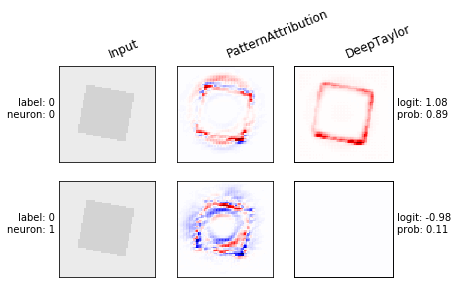

--------------------------------------------------------------------------------
Image nr. 787; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

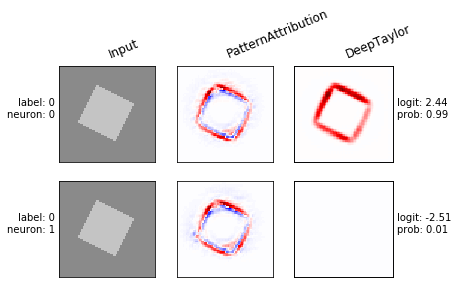

--------------------------------------------------------------------------------
Image nr. 788; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

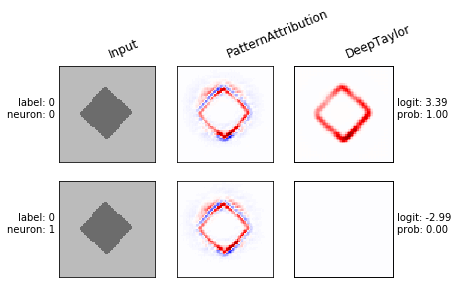

--------------------------------------------------------------------------------
Image nr. 789; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

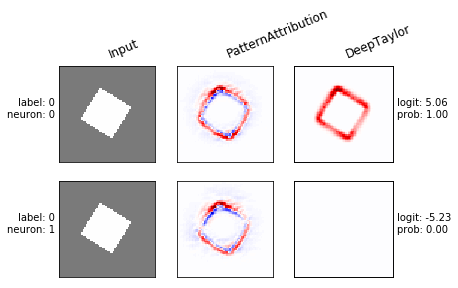

--------------------------------------------------------------------------------
Image nr. 790; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

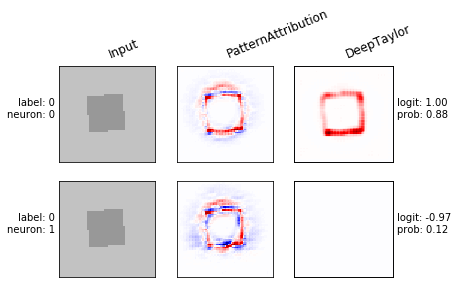

--------------------------------------------------------------------------------
Image nr. 791; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

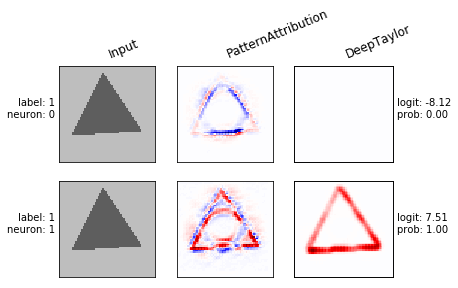

In [14]:
nim = len(labels_test_or)
ntim = 25
ind = int(np.random.randint(1,nim-ntim))
num_classes = 2

test_images = list(zip(images_test[ind:ind+ntim], labels_test_or[ind:ind+ntim]))
label_to_class_name = [str(i) for i in range(num_classes)]

for image_nr, (x, y) in enumerate(test_images):
    y = int(y)
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([num_classes, len(analyzers), 64, 64, 3])
    text = []

    for ii, output_neuron in enumerate([0, 1]):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))
       

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}; prediction: {} ".format(ind+image_nr, y_hat))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    print(label)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
   # row_labels_right = []
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
   # print(file_name)
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i" % output_neuron)+file_name.split(".")[-1]   
    n_rows = len(grid)
    n_cols = len(grid[0])
    figsize = (2*n_cols, 2*(n_rows+1))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, figsize=figsize, file_name=file_name)


Analyze subset of missclassified images with the different analyzers on all output neurons:

--------------------------------------------------------------------------------
Image nr. 767; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

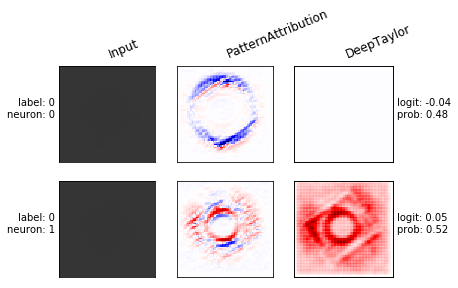

--------------------------------------------------------------------------------
Image nr. 768; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

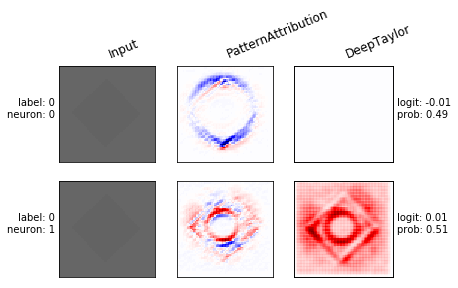

--------------------------------------------------------------------------------
Image nr. 769; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

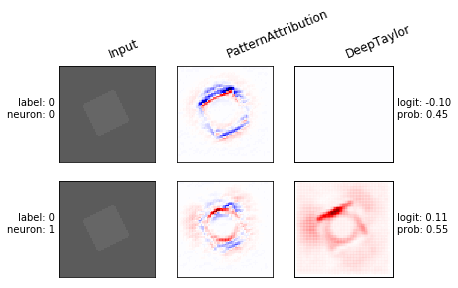

--------------------------------------------------------------------------------
Image nr. 770; prediction: 0 
('1', '1')


<Figure size 432x288 with 0 Axes>

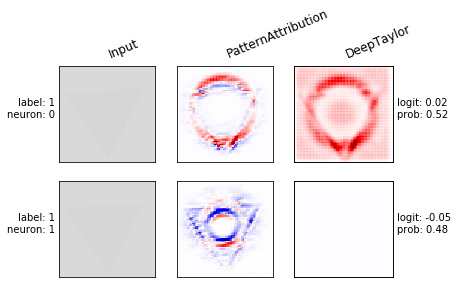

--------------------------------------------------------------------------------
Image nr. 771; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

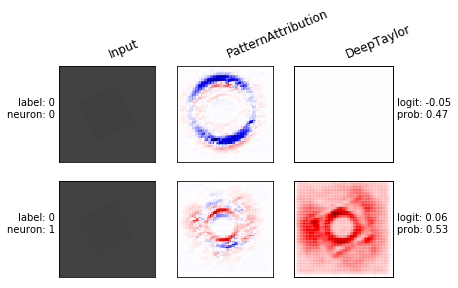

--------------------------------------------------------------------------------
Image nr. 772; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

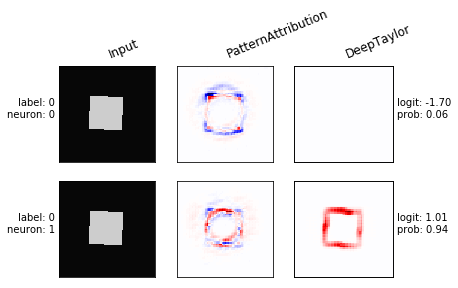

--------------------------------------------------------------------------------
Image nr. 773; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

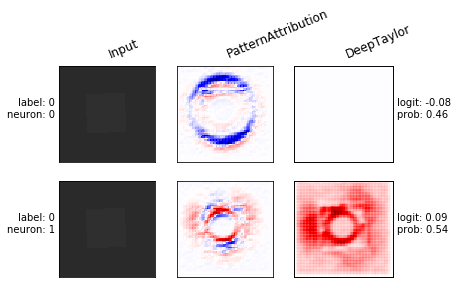

--------------------------------------------------------------------------------
Image nr. 774; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

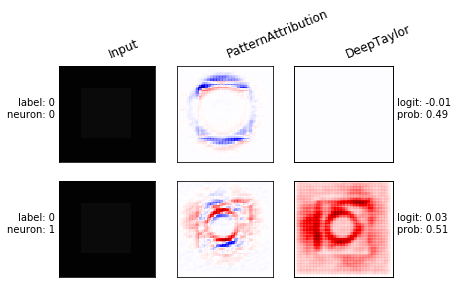

--------------------------------------------------------------------------------
Image nr. 775; prediction: 0 
('1', '1')


<Figure size 432x288 with 0 Axes>

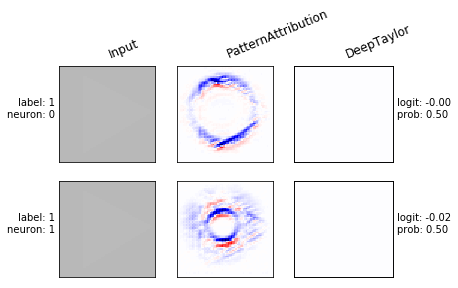

--------------------------------------------------------------------------------
Image nr. 776; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

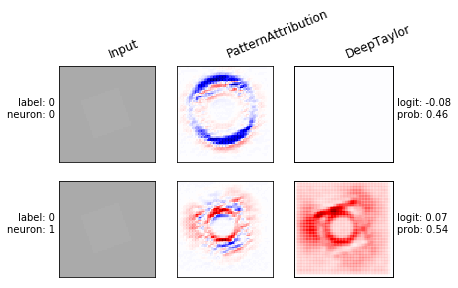

--------------------------------------------------------------------------------
Image nr. 777; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

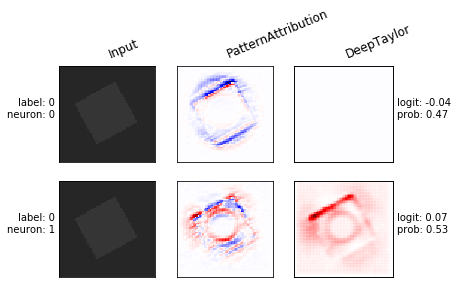

--------------------------------------------------------------------------------
Image nr. 778; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

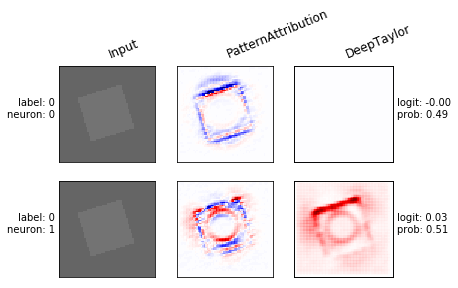

--------------------------------------------------------------------------------
Image nr. 779; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

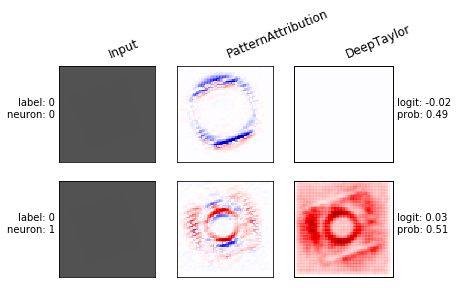

--------------------------------------------------------------------------------
Image nr. 780; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

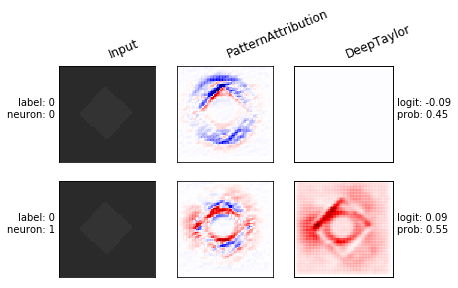

--------------------------------------------------------------------------------
Image nr. 781; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

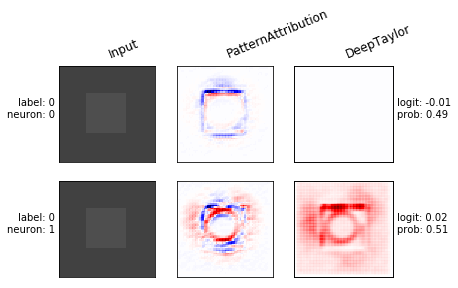

--------------------------------------------------------------------------------
Image nr. 782; prediction: 0 
('1', '1')


<Figure size 432x288 with 0 Axes>

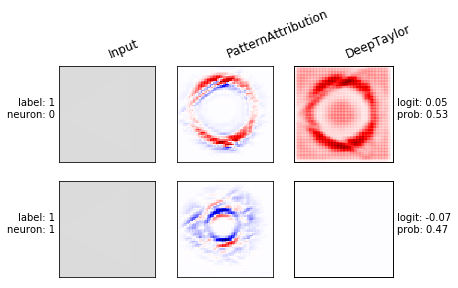

--------------------------------------------------------------------------------
Image nr. 783; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

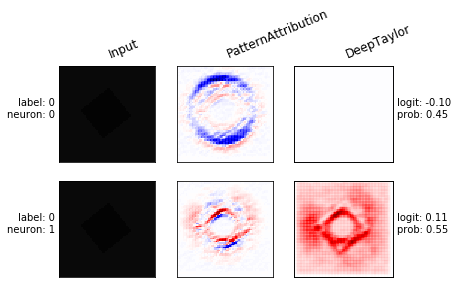

--------------------------------------------------------------------------------
Image nr. 784; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

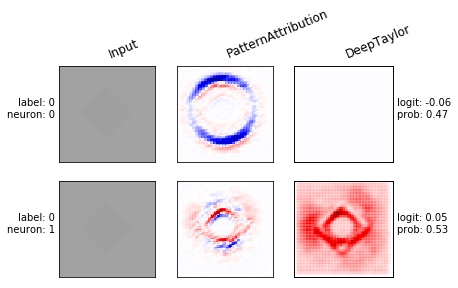

--------------------------------------------------------------------------------
Image nr. 785; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

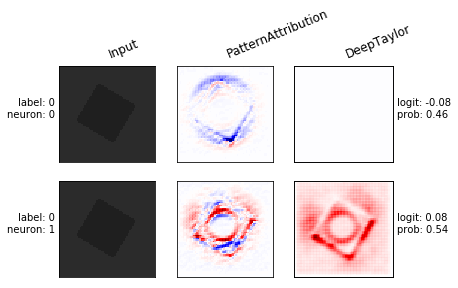

--------------------------------------------------------------------------------
Image nr. 786; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

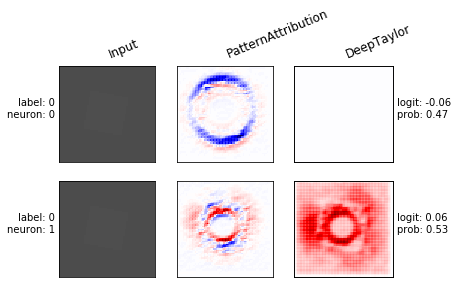

--------------------------------------------------------------------------------
Image nr. 787; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

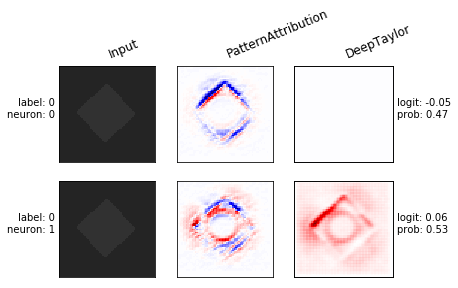

--------------------------------------------------------------------------------
Image nr. 788; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

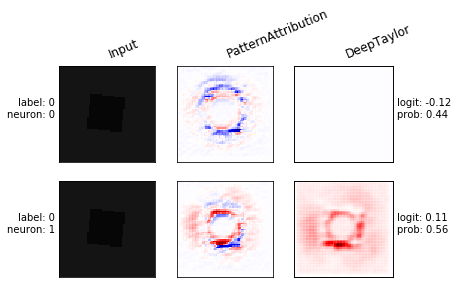

--------------------------------------------------------------------------------
Image nr. 789; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

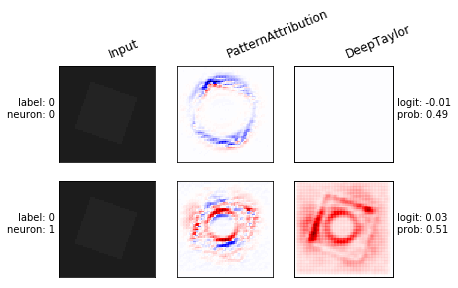

--------------------------------------------------------------------------------
Image nr. 790; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

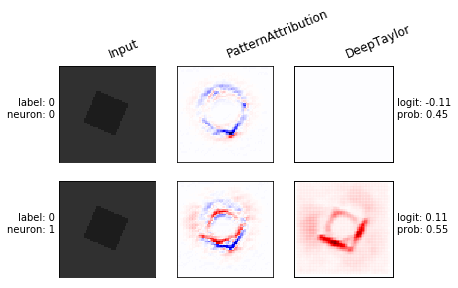

--------------------------------------------------------------------------------
Image nr. 791; prediction: 1 
('0', '0')


<Figure size 432x288 with 0 Axes>

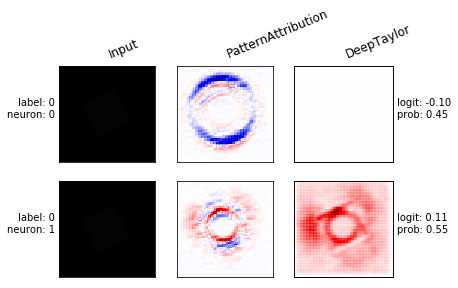

In [15]:
nim = len(indices_wrong)
ntim = 25
indices = indices_wrong[0:ntim]
num_classes = 2

test_images = list(zip(images_test[indices], labels_test_or[indices]))
label_to_class_name = [str(i) for i in range(num_classes)]

for image_nr, (x, y) in enumerate(test_images):
    y = int(y)
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([num_classes, len(analyzers), 64, 64, 3])
    text = []

    for ii, output_neuron in enumerate([0, 1]):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))
       

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}; prediction: {} ".format(ind+image_nr, y_hat))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    print(label)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
   # row_labels_right = []
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
   # print(file_name)
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i" % output_neuron)+file_name.split(".")[-1]   
    n_rows = len(grid)
    n_cols = len(grid[0])
    figsize = (2*n_cols, 2*(n_rows+1))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, figsize=figsize, file_name=file_name)
